# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=5,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-46-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4996 | MulticlassF1Score=0.1537
Batch-30 : CrossEntropyLoss=2.4667 | MulticlassF1Score=0.2279
Batch-45 : CrossEntropyLoss=2.3782 | MulticlassF1Score=0.3052
Batch-60 : CrossEntropyLoss=2.3979 | MulticlassF1Score=0.3689
Batch-75 : CrossEntropyLoss=2.3822 | MulticlassF1Score=0.4152
Batch-90 : CrossEntropyLoss=2.3563 | MulticlassF1Score=0.4540
Batch-105: CrossEntropyLoss=2.3530 | MulticlassF1Score=0.4836
Batch-120: CrossEntropyLoss=2.3672 | MulticlassF1Score=0.5039
Batch-135: CrossEntropyLoss=2.3639 | MulticlassF1Score=0.5226
Batch-150: CrossEntropyLoss=2.3502 | MulticlassF1Score=0.5375
Batch-165: CrossEntropyLoss=2.3575 | MulticlassF1Score=0.5502
Batch-180: CrossEntropyLoss=2.3369 | MulticlassF1Score=0.5605
Batch-195: CrossEntropyLoss=2.3551 | MulticlassF1Score=0.5686
Batch-210: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.5765
Batch-225: CrossEntropyLoss=2.3414 | MulticlassF1Score=0.5836
Batch-226: CrossEntropyLoss=2.3357 | MulticlassF1Score=0.5840

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3377 | MulticlassF1Score=0.7057
Batch-30 : CrossEntropyLoss=2.3328 | MulticlassF1Score=0.7087
Batch-45 : CrossEntropyLoss=2.3344 | MulticlassF1Score=0.7079
Batch-60 : CrossEntropyLoss=2.3318 | MulticlassF1Score=0.7091
Batch-63 : CrossEntropyLoss=2.3318 | MulticlassF1Score=0.7088

Training   : Mean CrossEntropyLoss = 2.3884 | Mean MulticlassF1Score = 0.4391
Validation : Mean CrossEntropyLoss = 2.3403 | Mean MulticlassF1Score = 0.7099

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3243 | MulticlassF1Score=0.7156
Batch-30 : CrossEntropyLoss=2.3251 | MulticlassF1Score=0.7192
Batch-45 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7324
Batch-60 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7409
Batch-75 : CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7512
Batch-90 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.7560
Batch-105: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7615
Batch-120: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7656
Batch-135: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7685
Batch-150: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7702
Batch-165: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.7725
Batch-180: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7748
Batch-195: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7764
Batch-210: CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7782
Batch-225: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.7802
Batch-226: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.7803

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3151 | MulticlassF1Score=0.8005
Batch-30 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8001
Batch-45 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8011
Batch-60 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7992
Batch-63 : CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7991

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3170 | Mean MulticlassF1Score = 0.7555
Validation : Mean CrossEntropyLoss = 2.3102 | Mean MulticlassF1Score = 0.8024

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.8008
Batch-30 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8024
Batch-45 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8038
Batch-60 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8043
Batch-75 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8058
Batch-90 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8056
Batch-105: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8048
Batch-120: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8065
Batch-135: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8063
Batch-150: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8067
Batch-165: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8065
Batch-180: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8060
Batch-195: CrossEntropyLoss=2.3141 | MulticlassF1Score=0.8058
Batch-210: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8054
Batch-225: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8056
Batch-226: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.8056

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8013
Batch-30 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8004
Batch-45 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8000
Batch-60 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8015
Batch-63 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.8012

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3082 | Mean MulticlassF1Score = 0.8049
Validation : Mean CrossEntropyLoss = 2.3093 | Mean MulticlassF1Score = 0.8002

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8090
Batch-30 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8075
Batch-45 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.8064
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8061
Batch-75 : CrossEntropyLoss=2.3147 | MulticlassF1Score=0.8058
Batch-90 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8060
Batch-105: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8071
Batch-120: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8093
Batch-135: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8118
Batch-150: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8145
Batch-165: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8163
Batch-180: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8181
Batch-195: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8194
Batch-210: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8208
Batch-225: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8215
Batch-226: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8216

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8275
Batch-30 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8291
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8298
Batch-60 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8313
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8317

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3031 | Mean MulticlassF1Score = 0.8112
Validation : Mean CrossEntropyLoss = 2.2998 | Mean MulticlassF1Score = 0.8296

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8438
Batch-30 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8412
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8408
Batch-60 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8398
Batch-75 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8400
Batch-90 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8402
Batch-105: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8400
Batch-120: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8401
Batch-135: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8399
Batch-150: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8398
Batch-165: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8400
Batch-180: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8395
Batch-195: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8396
Batch-210: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8397
Batch-225: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8391
Batch-226: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8366
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8358
Batch-45 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8347
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8341
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8332

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2976 | Mean MulticlassF1Score = 0.8404
Validation : Mean CrossEntropyLoss = 2.2992 | Mean MulticlassF1Score = 0.8356

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8383
Batch-30 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8413
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8411
Batch-60 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8409
Batch-75 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8415
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8424
Batch-105: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8415
Batch-120: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8420
Batch-135: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8419
Batch-150: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8415
Batch-165: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8416
Batch-180: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8412
Batch-195: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8412
Batch-210: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8414
Batch-225: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8409
Batch-226: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8337
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8325
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8335
Batch-63 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8337

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2969 | Mean MulticlassF1Score = 0.8408
Validation : Mean CrossEntropyLoss = 2.2990 | Mean MulticlassF1Score = 0.8326

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8455
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8407
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8418
Batch-60 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8417
Batch-75 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8428
Batch-90 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8434
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8434
Batch-120: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8427
Batch-135: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8423
Batch-150: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8429
Batch-165: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8426
Batch-180: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8430
Batch-195: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8425
Batch-210: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8422
Batch-225: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8421
Batch-226: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8359
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8353
Batch-45 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8355
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8344
Batch-63 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8342

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8428
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8359

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8438
Batch-30 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8449
Batch-45 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8432
Batch-60 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8429
Batch-75 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8431
Batch-90 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8435
Batch-105: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8444
Batch-120: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8439
Batch-135: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8428
Batch-150: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8432
Batch-165: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8436
Batch-180: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8436
Batch-195: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8432
Batch-210: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8434
Batch-225: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8434
Batch-226: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8356
Batch-30 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8340
Batch-45 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8358
Batch-60 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8362
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8359

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8435
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8354

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8395
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8439
Batch-45 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8456
Batch-60 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8454
Batch-75 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8440
Batch-90 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8438
Batch-105: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8445
Batch-120: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8447
Batch-135: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8443
Batch-150: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8450
Batch-165: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8454
Batch-180: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8448
Batch-195: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8450
Batch-210: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8450
Batch-225: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8451
Batch-226: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.8450

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8286
Batch-30 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8325
Batch-45 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8345
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8350
Batch-63 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8349

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2955 | Mean MulticlassF1Score = 0.8443
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8303

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8434
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8456
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8455
Batch-60 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8457
Batch-75 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8448
Batch-90 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8449
Batch-105: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8451
Batch-120: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8450
Batch-135: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8452
Batch-150: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8456
Batch-165: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8458
Batch-180: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8461
Batch-195: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8463
Batch-210: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8466
Batch-225: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8466
Batch-226: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8425
Batch-30 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8396
Batch-45 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8401
Batch-60 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8384
Batch-63 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8386

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2950 | Mean MulticlassF1Score = 0.8455
Validation : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8392

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8510
Batch-30 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8514
Batch-45 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8526
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8537
Batch-75 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8524
Batch-90 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8510
Batch-105: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8507
Batch-120: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8525
Batch-135: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8537
Batch-150: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8551
Batch-165: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8567
Batch-180: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8578
Batch-195: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8587
Batch-210: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8595
Batch-225: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8605
Batch-226: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8605

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8639
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8617
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8640
Batch-60 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8642
Batch-63 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8643

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2909 | Mean MulticlassF1Score = 0.8540
Validation : Mean CrossEntropyLoss = 2.2896 | Mean MulticlassF1Score = 0.8643

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8836
Batch-30 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8775
Batch-60 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8794
Batch-75 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8785
Batch-90 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8786
Batch-105: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8784
Batch-120: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8788
Batch-135: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8787
Batch-150: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8791
Batch-165: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8790
Batch-180: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8785
Batch-195: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8779
Batch-210: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8783
Batch-225: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8782
Batch-226: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8782

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8708
Batch-30 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8718
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8705
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8693
Batch-63 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8695

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8789
Validation : Mean CrossEntropyLoss = 2.2880 | Mean MulticlassF1Score = 0.8711

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8856
Batch-30 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8847
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8850
Batch-60 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8837
Batch-75 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8831
Batch-90 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8832
Batch-105: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8820
Batch-120: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8818
Batch-135: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8812
Batch-150: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8811
Batch-165: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8811
Batch-180: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8813
Batch-195: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8811
Batch-210: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8811
Batch-225: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8812
Batch-226: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8812

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8716
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8729
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8710
Batch-60 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8702
Batch-63 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8698

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8826
Validation : Mean CrossEntropyLoss = 2.2878 | Mean MulticlassF1Score = 0.8722

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8838
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8851
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8846
Batch-75 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8841
Batch-90 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8846
Batch-105: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8843
Batch-120: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8839
Batch-135: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8841
Batch-150: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8834
Batch-165: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8833
Batch-180: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8833
Batch-195: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8827
Batch-210: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8830
Batch-225: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8829
Batch-226: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8829

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8713
Batch-30 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8702
Batch-45 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8691
Batch-60 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8708
Batch-63 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8702

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2838 | Mean MulticlassF1Score = 0.8840
Validation : Mean CrossEntropyLoss = 2.2875 | Mean MulticlassF1Score = 0.8709

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8856
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8849
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8854
Batch-90 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8861
Batch-105: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8860
Batch-120: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8853
Batch-135: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8845
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8845
Batch-165: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8846
Batch-180: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8849
Batch-195: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8850
Batch-210: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8850
Batch-225: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8845
Batch-226: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8845

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8704
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8682
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8686
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8700
Batch-63 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8706

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8851
Validation : Mean CrossEntropyLoss = 2.2875 | Mean MulticlassF1Score = 0.8692

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8790
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8797
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8818
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8828
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8821
Batch-90 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8825
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8836
Batch-120: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8843
Batch-135: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8850
Batch-150: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8845
Batch-165: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8850
Batch-180: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8861
Batch-195: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8870
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8880
Batch-225: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8891
Batch-226: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8891

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8880
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8877
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8866
Batch-63 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8868

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8840
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8858

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9069
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9022
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9037
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9046
Batch-75 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9040
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9050
Batch-105: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.9042
Batch-120: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9044
Batch-135: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9044
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9048
Batch-180: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9046
Batch-195: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9048
Batch-210: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9050
Batch-225: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9050
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9050

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8902
Batch-45 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8916
Batch-63 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8918

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9049
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8915

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9061
Batch-45 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9068
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9066
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9059
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9060
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9075
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9069
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.9068
Batch-150: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9068
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9073
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9074
Batch-195: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9074
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9073
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.9074
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9074

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8934
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8937
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8946
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8934
Batch-63 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8926

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9066
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8942

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9122
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9129
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9121
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9118
Batch-75 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9103
Batch-90 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9111
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9141
Batch-120: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9155
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9171
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9182
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9192
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9204
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9211
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9216
Batch-225: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9219
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9220

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9169
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9167

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9154
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9193

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9319
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9326
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9337
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9343
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9346
Batch-105: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9346
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9349
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9356
Batch-150: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9358
Batch-165: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9361
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9359
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9346
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9217

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9401
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9399
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9400
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9405
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9404
Batch-225: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9403
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9250

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9444
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9434
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9426
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9426

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9263

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9433
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9262

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9439
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9236

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9286

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9451
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9233

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9449
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9257

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9460
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9456
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9270

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9452
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9449
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9451
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9457
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9271

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9459
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9261

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9480
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9471
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9466
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9276

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9470
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9475
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9476
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9471
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9468
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9468
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9468

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9265

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9482
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9472
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9475
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9475
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9476
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9474
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9252

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9463
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9471
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9475
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9279

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9476
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9476
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9476
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9266

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9260
Patience = 1/50❗

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9478
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9480
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9475
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9471
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9475
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9278

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9496
Batch-75 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9489
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9488
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9485
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9478
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9477
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9480
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9478
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9477

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9275

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9494
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9494
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9490
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9493
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9488
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9486
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9484
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9483
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9486
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9243

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9483
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9482
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9480
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9484
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9269

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9507
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9487
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9488
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9487
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9489
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9487
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9484
Batch-225: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9481
Batch-226: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9490
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9283

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9486
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9492
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9487
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9493
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9491
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9490
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9490
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9501
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9512
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9513

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9456

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2625 | Mean MulticlassF1Score = 0.9490
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9461

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9668
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9470

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9454

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9455

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9456
Patience = 2/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9453
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9429

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9462

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9461
Patience = 3/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9693
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9479

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9461

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9457

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9481

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9706
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9700
Batch-165: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9702
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9469

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2566
Best CrossEntropyLoss training    : 2.2636
Best MulticlassF1Score validation : 0.9702
Best MulticlassF1Score validation : 0.9469
Training duration                 : 2.8068 minutes.
Training date                     : 2022-10-19 13:43:05.587109+08:00


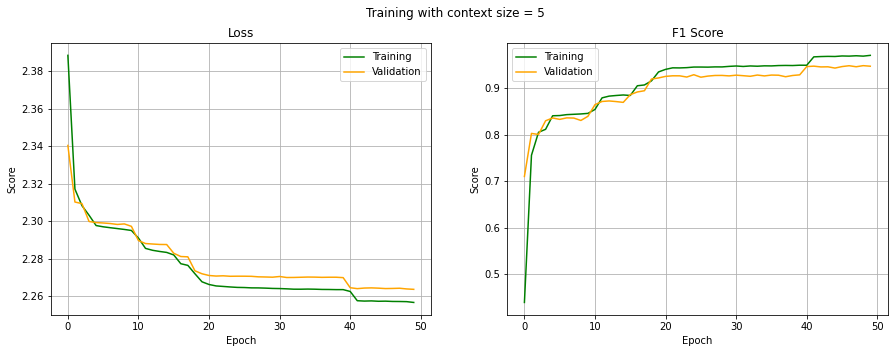

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9714, device='cuda:0'),
 tensor(0.9477, device='cuda:0'),
 tensor(0.9491, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9714, device='cuda:0'),
 tensor(0.9477, device='cuda:0'),
 tensor(0.9491, device='cuda:0'))

## Heatmap

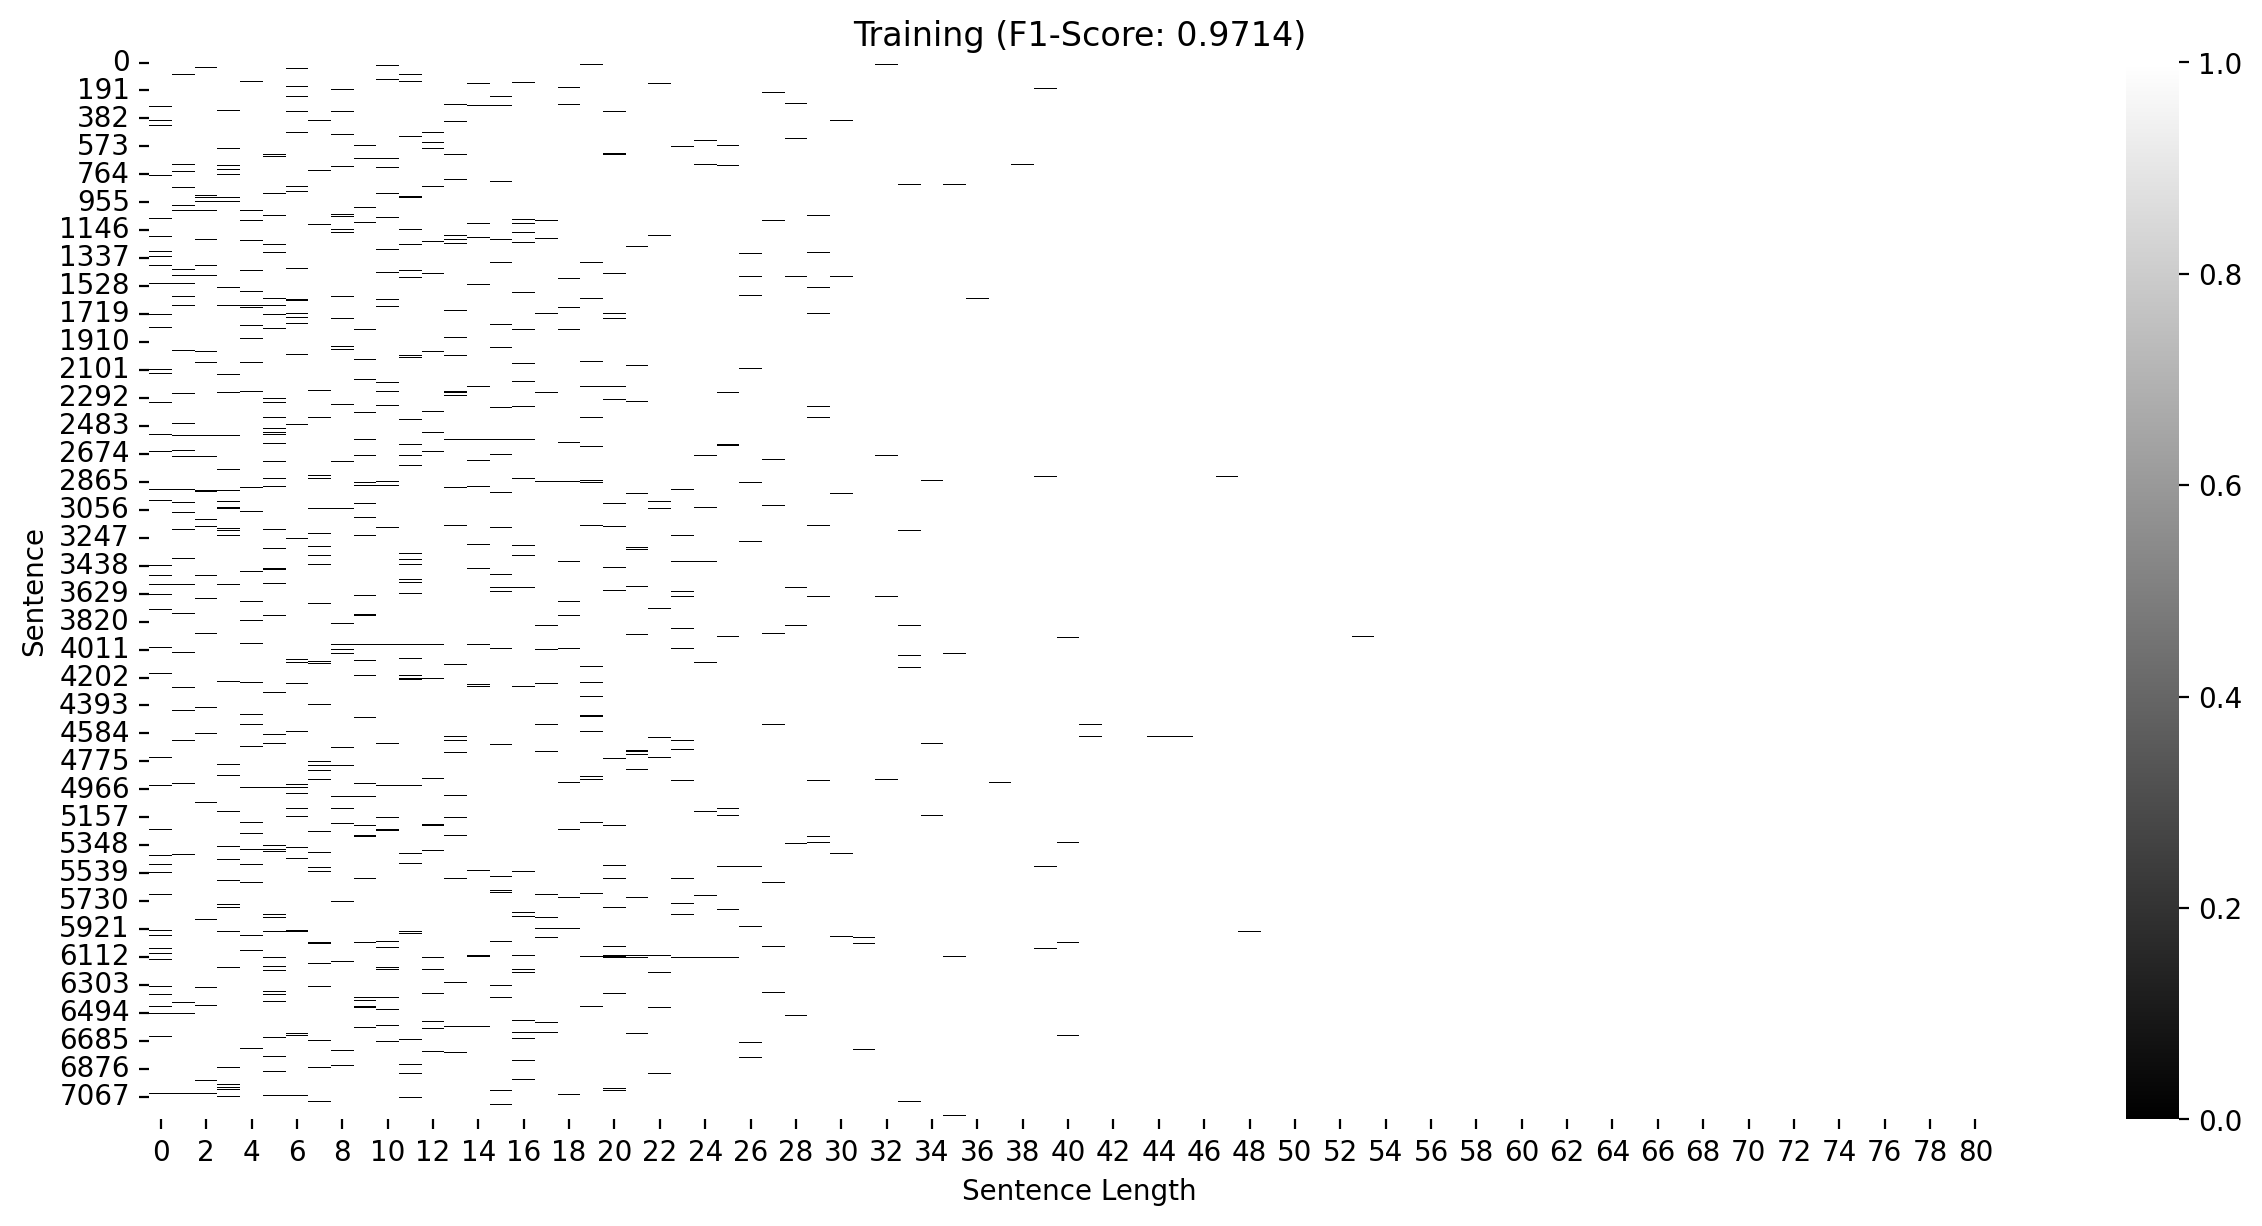

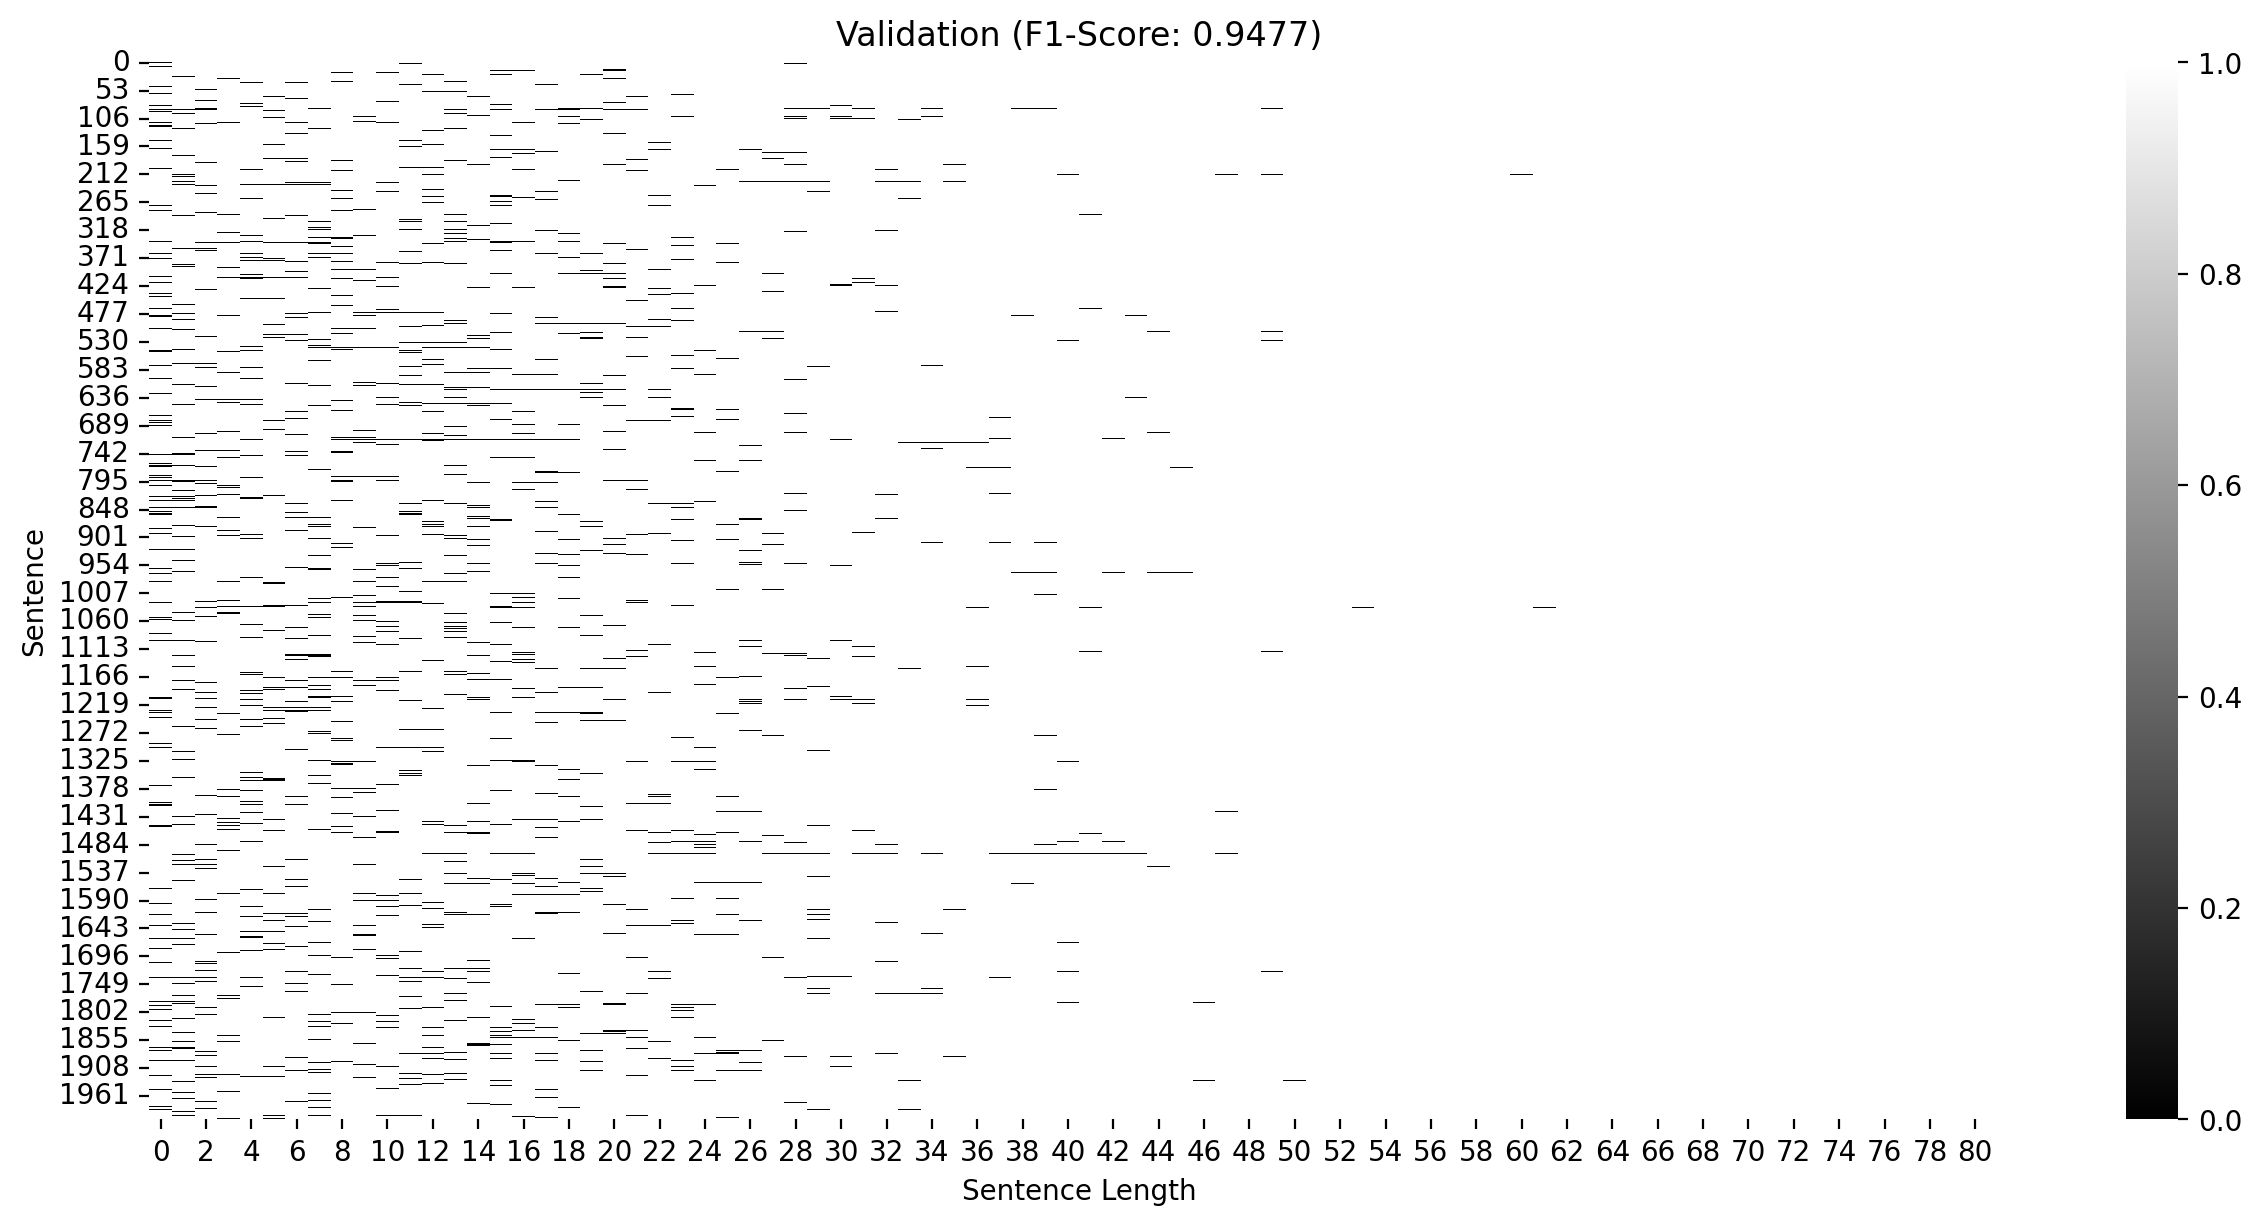

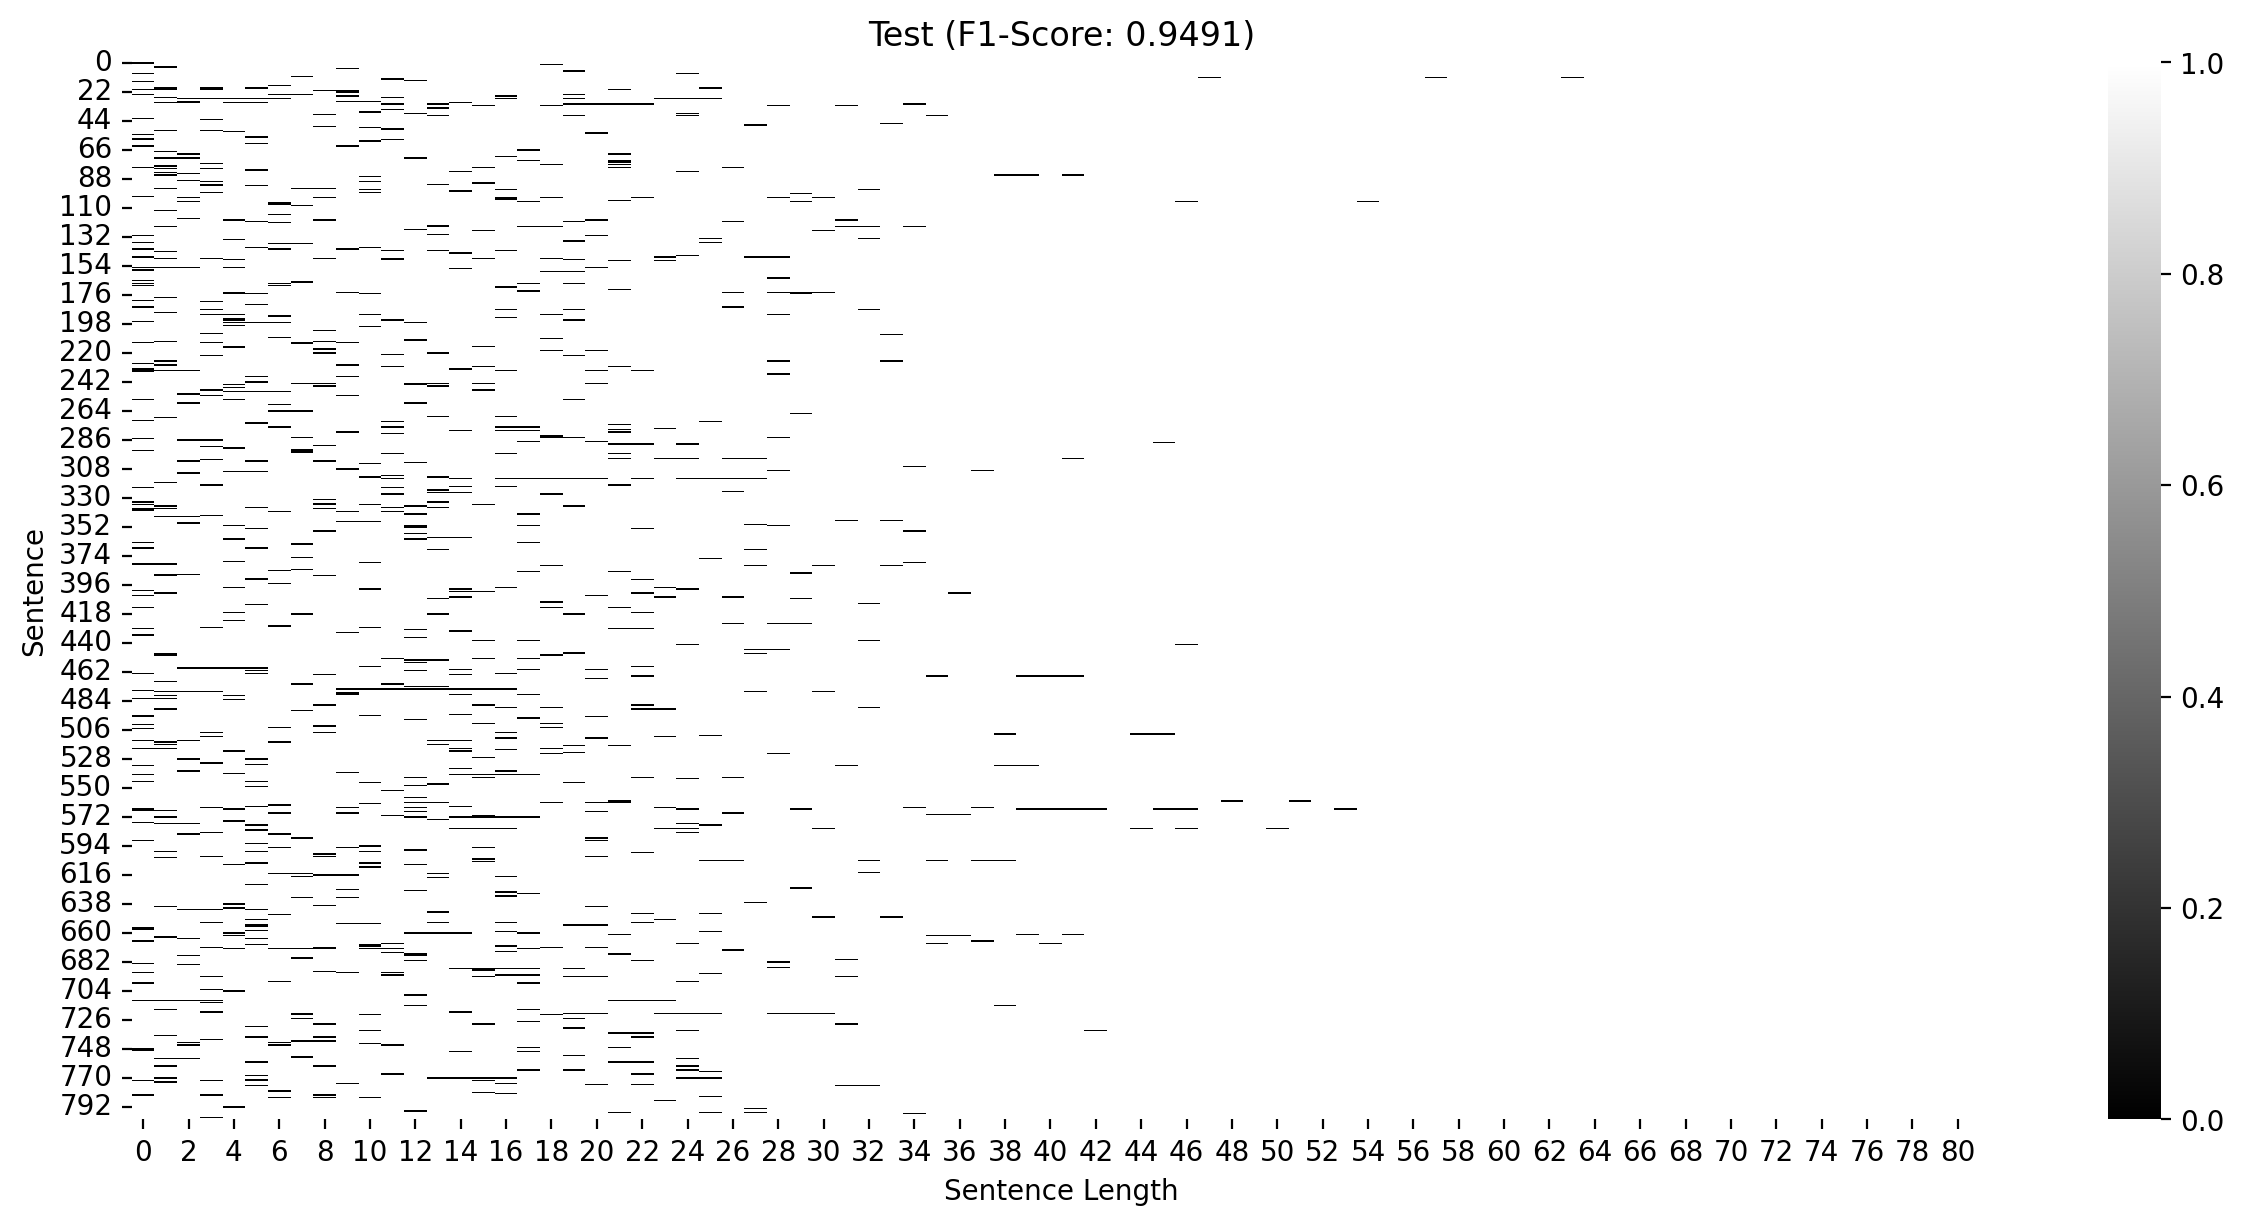

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


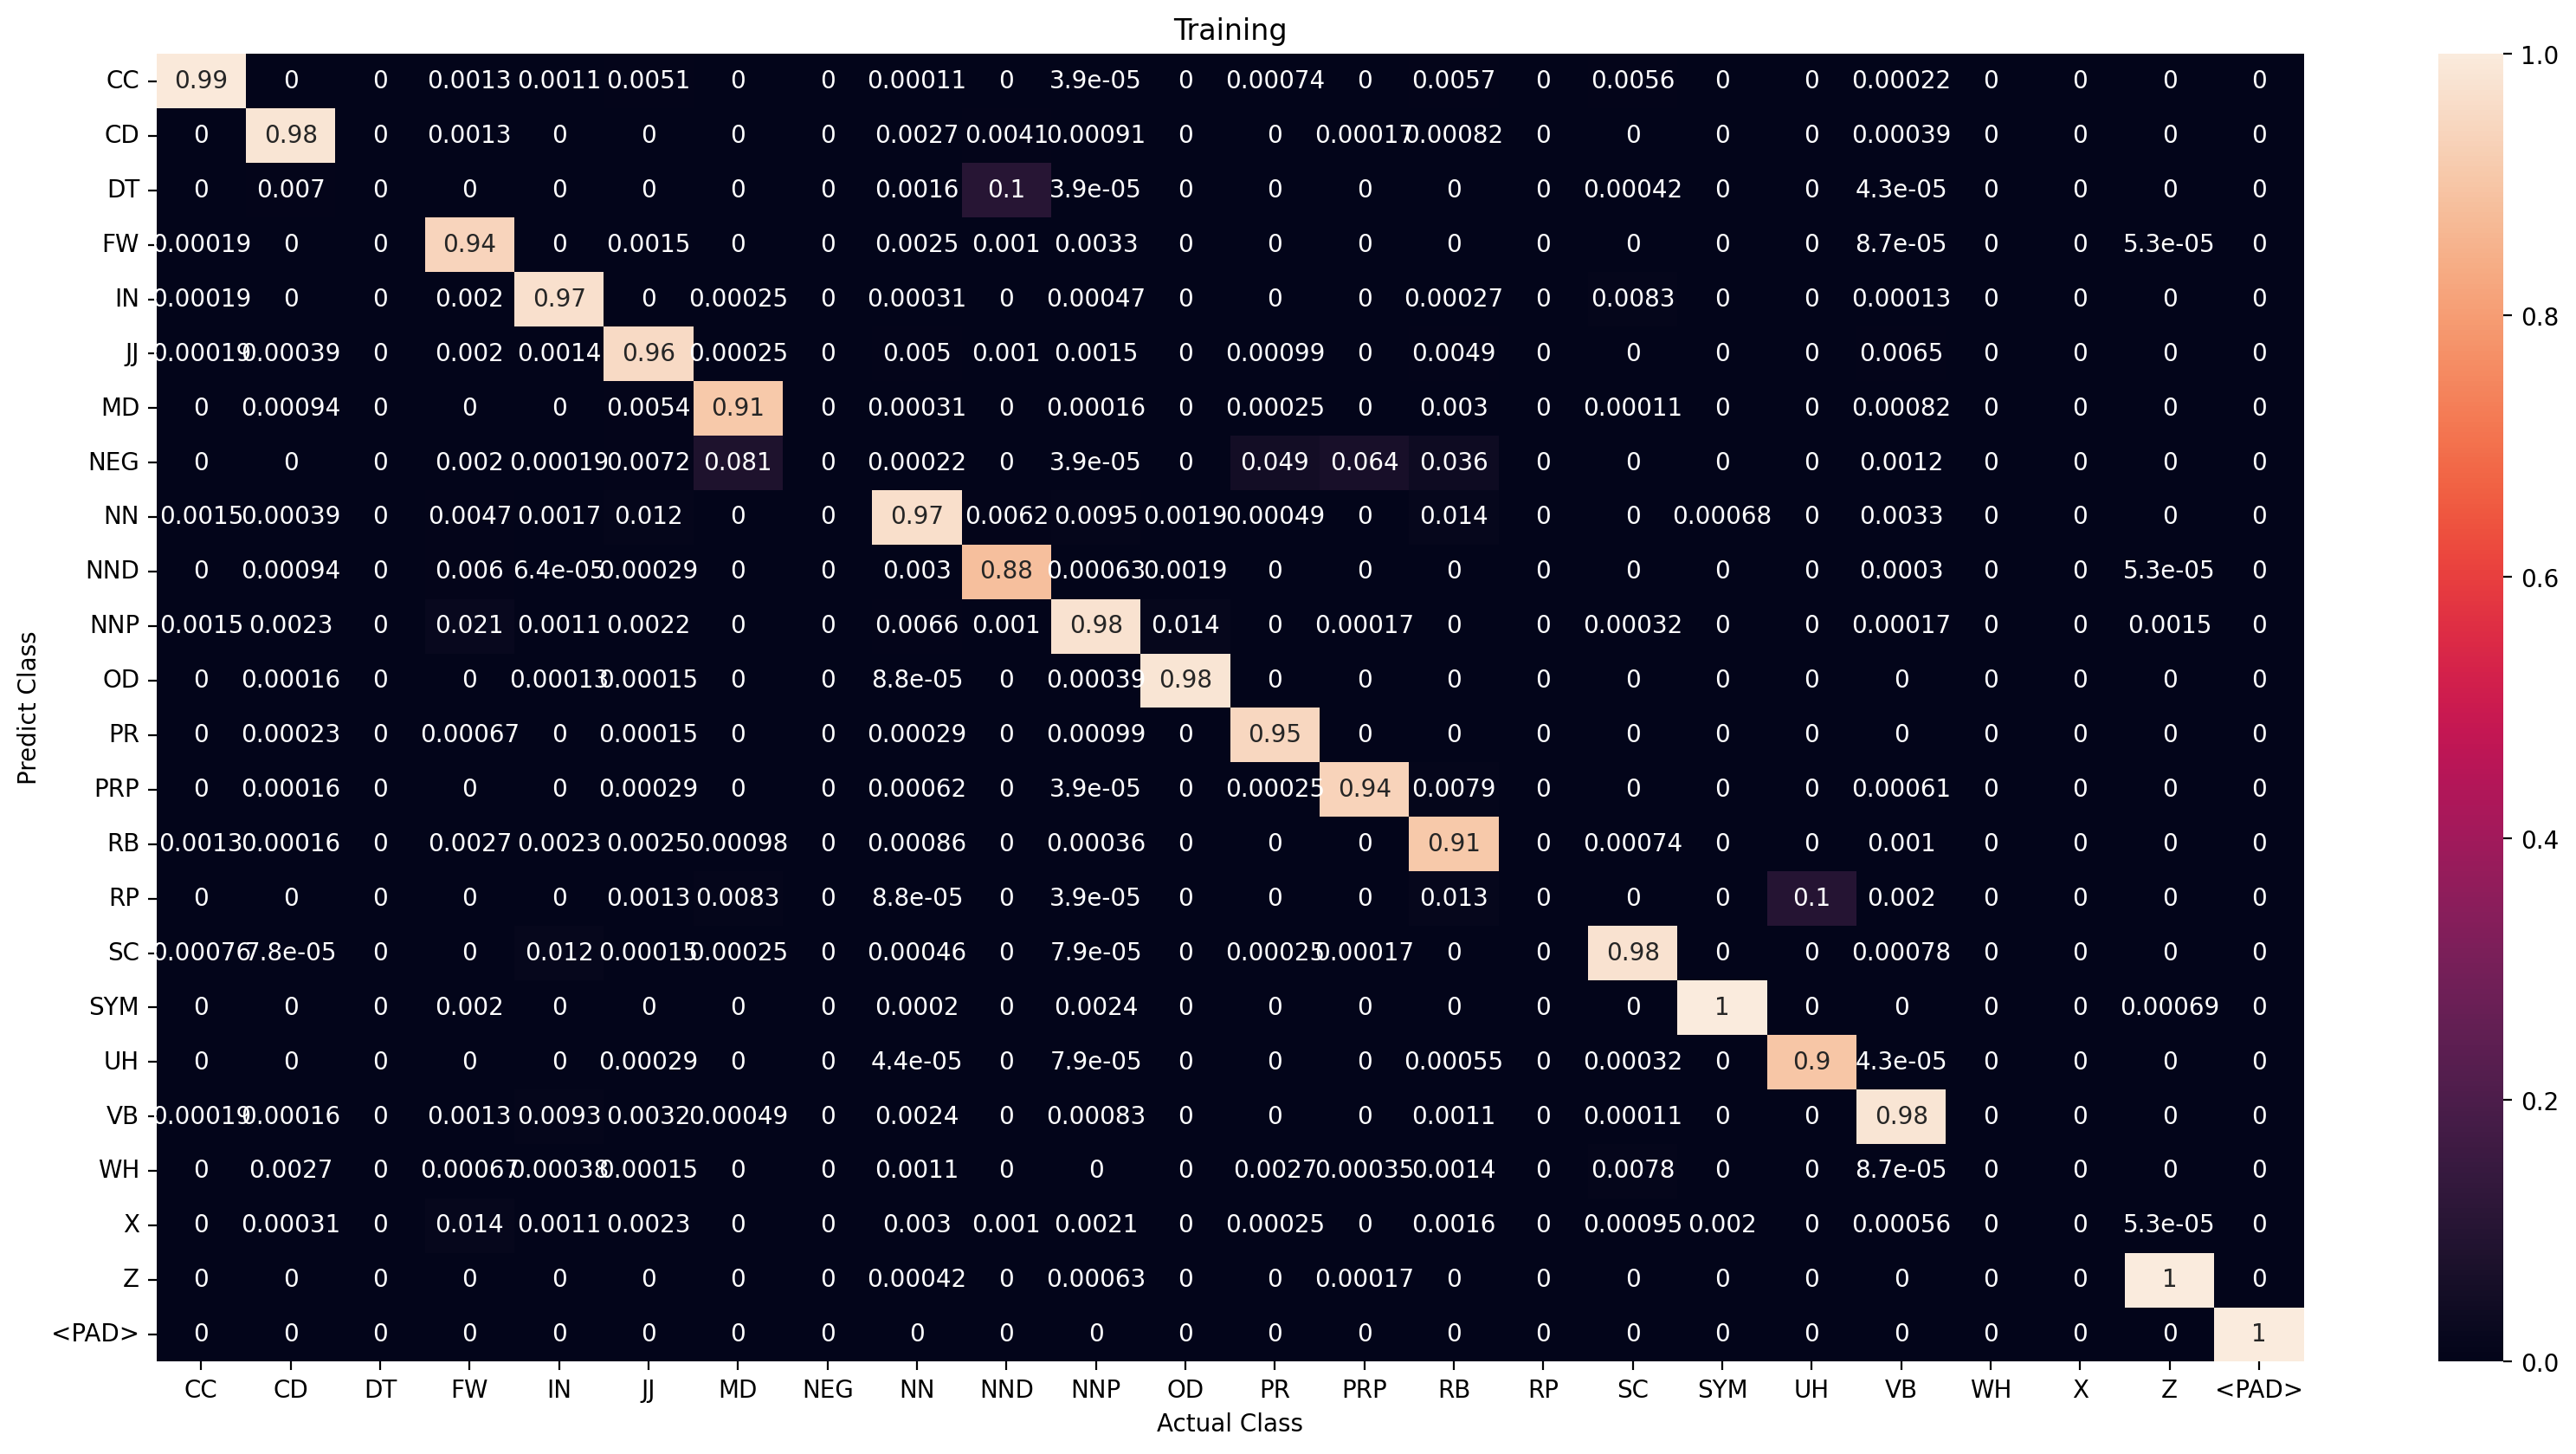

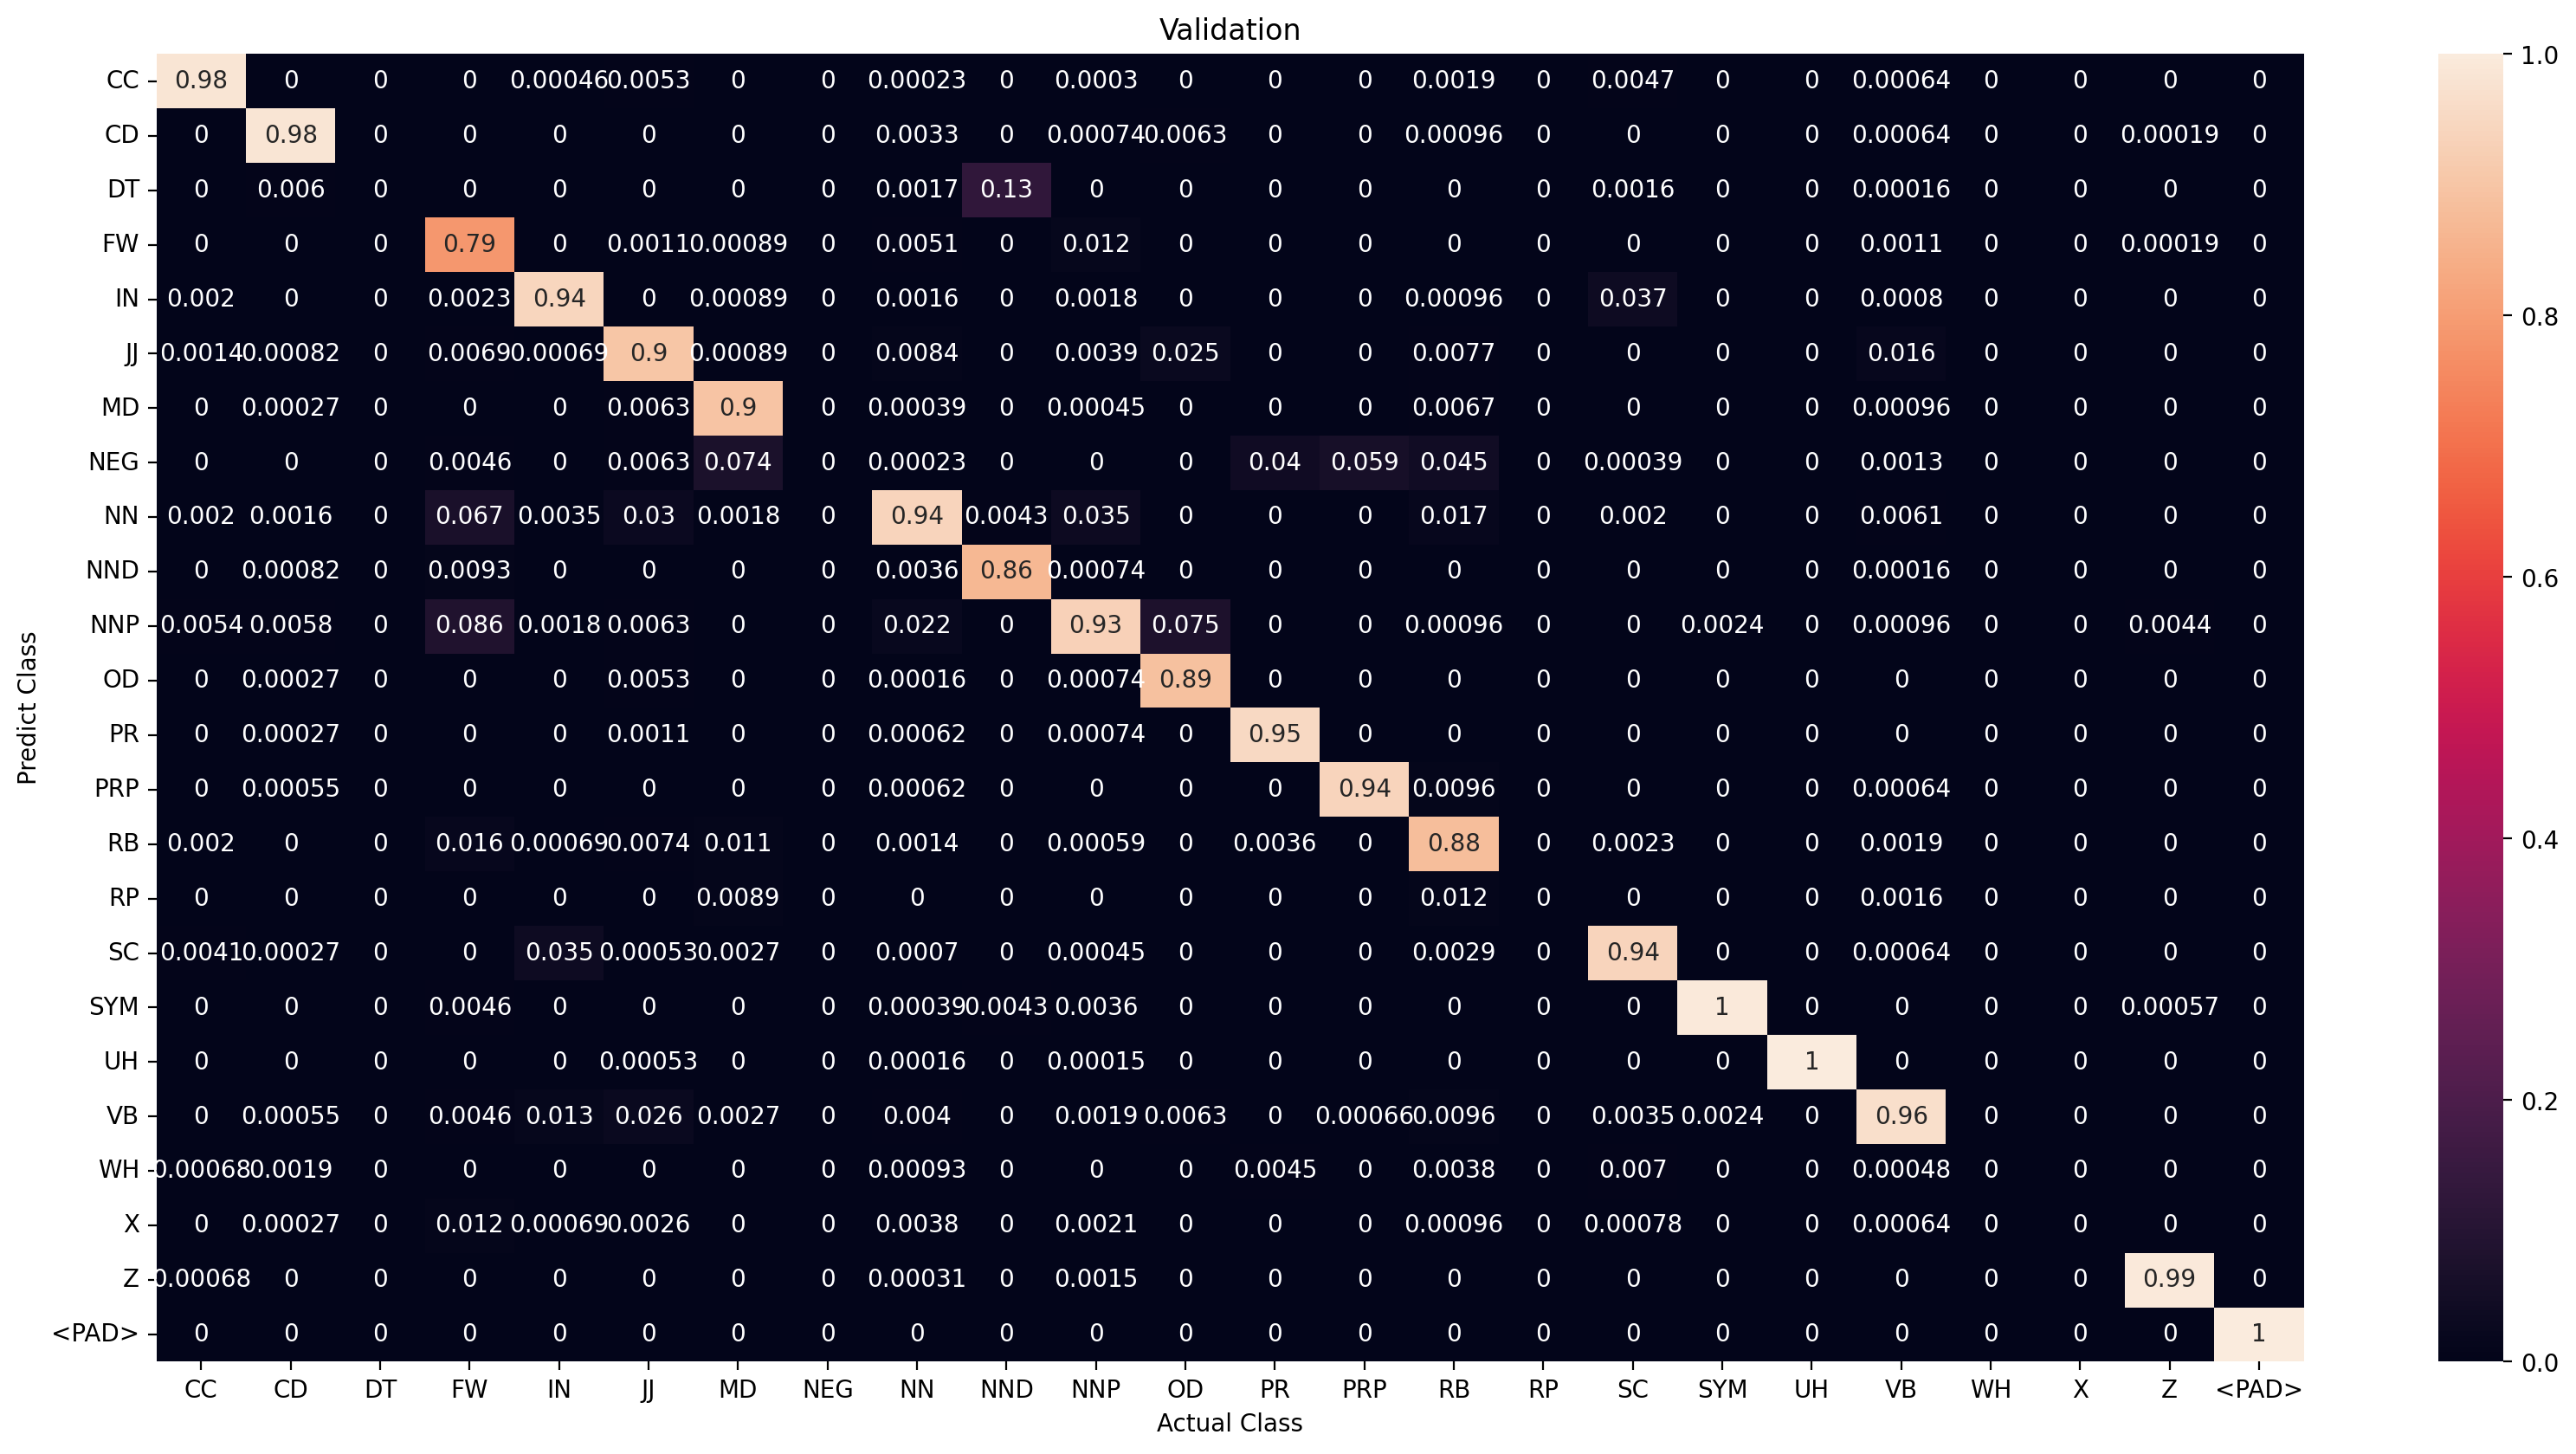

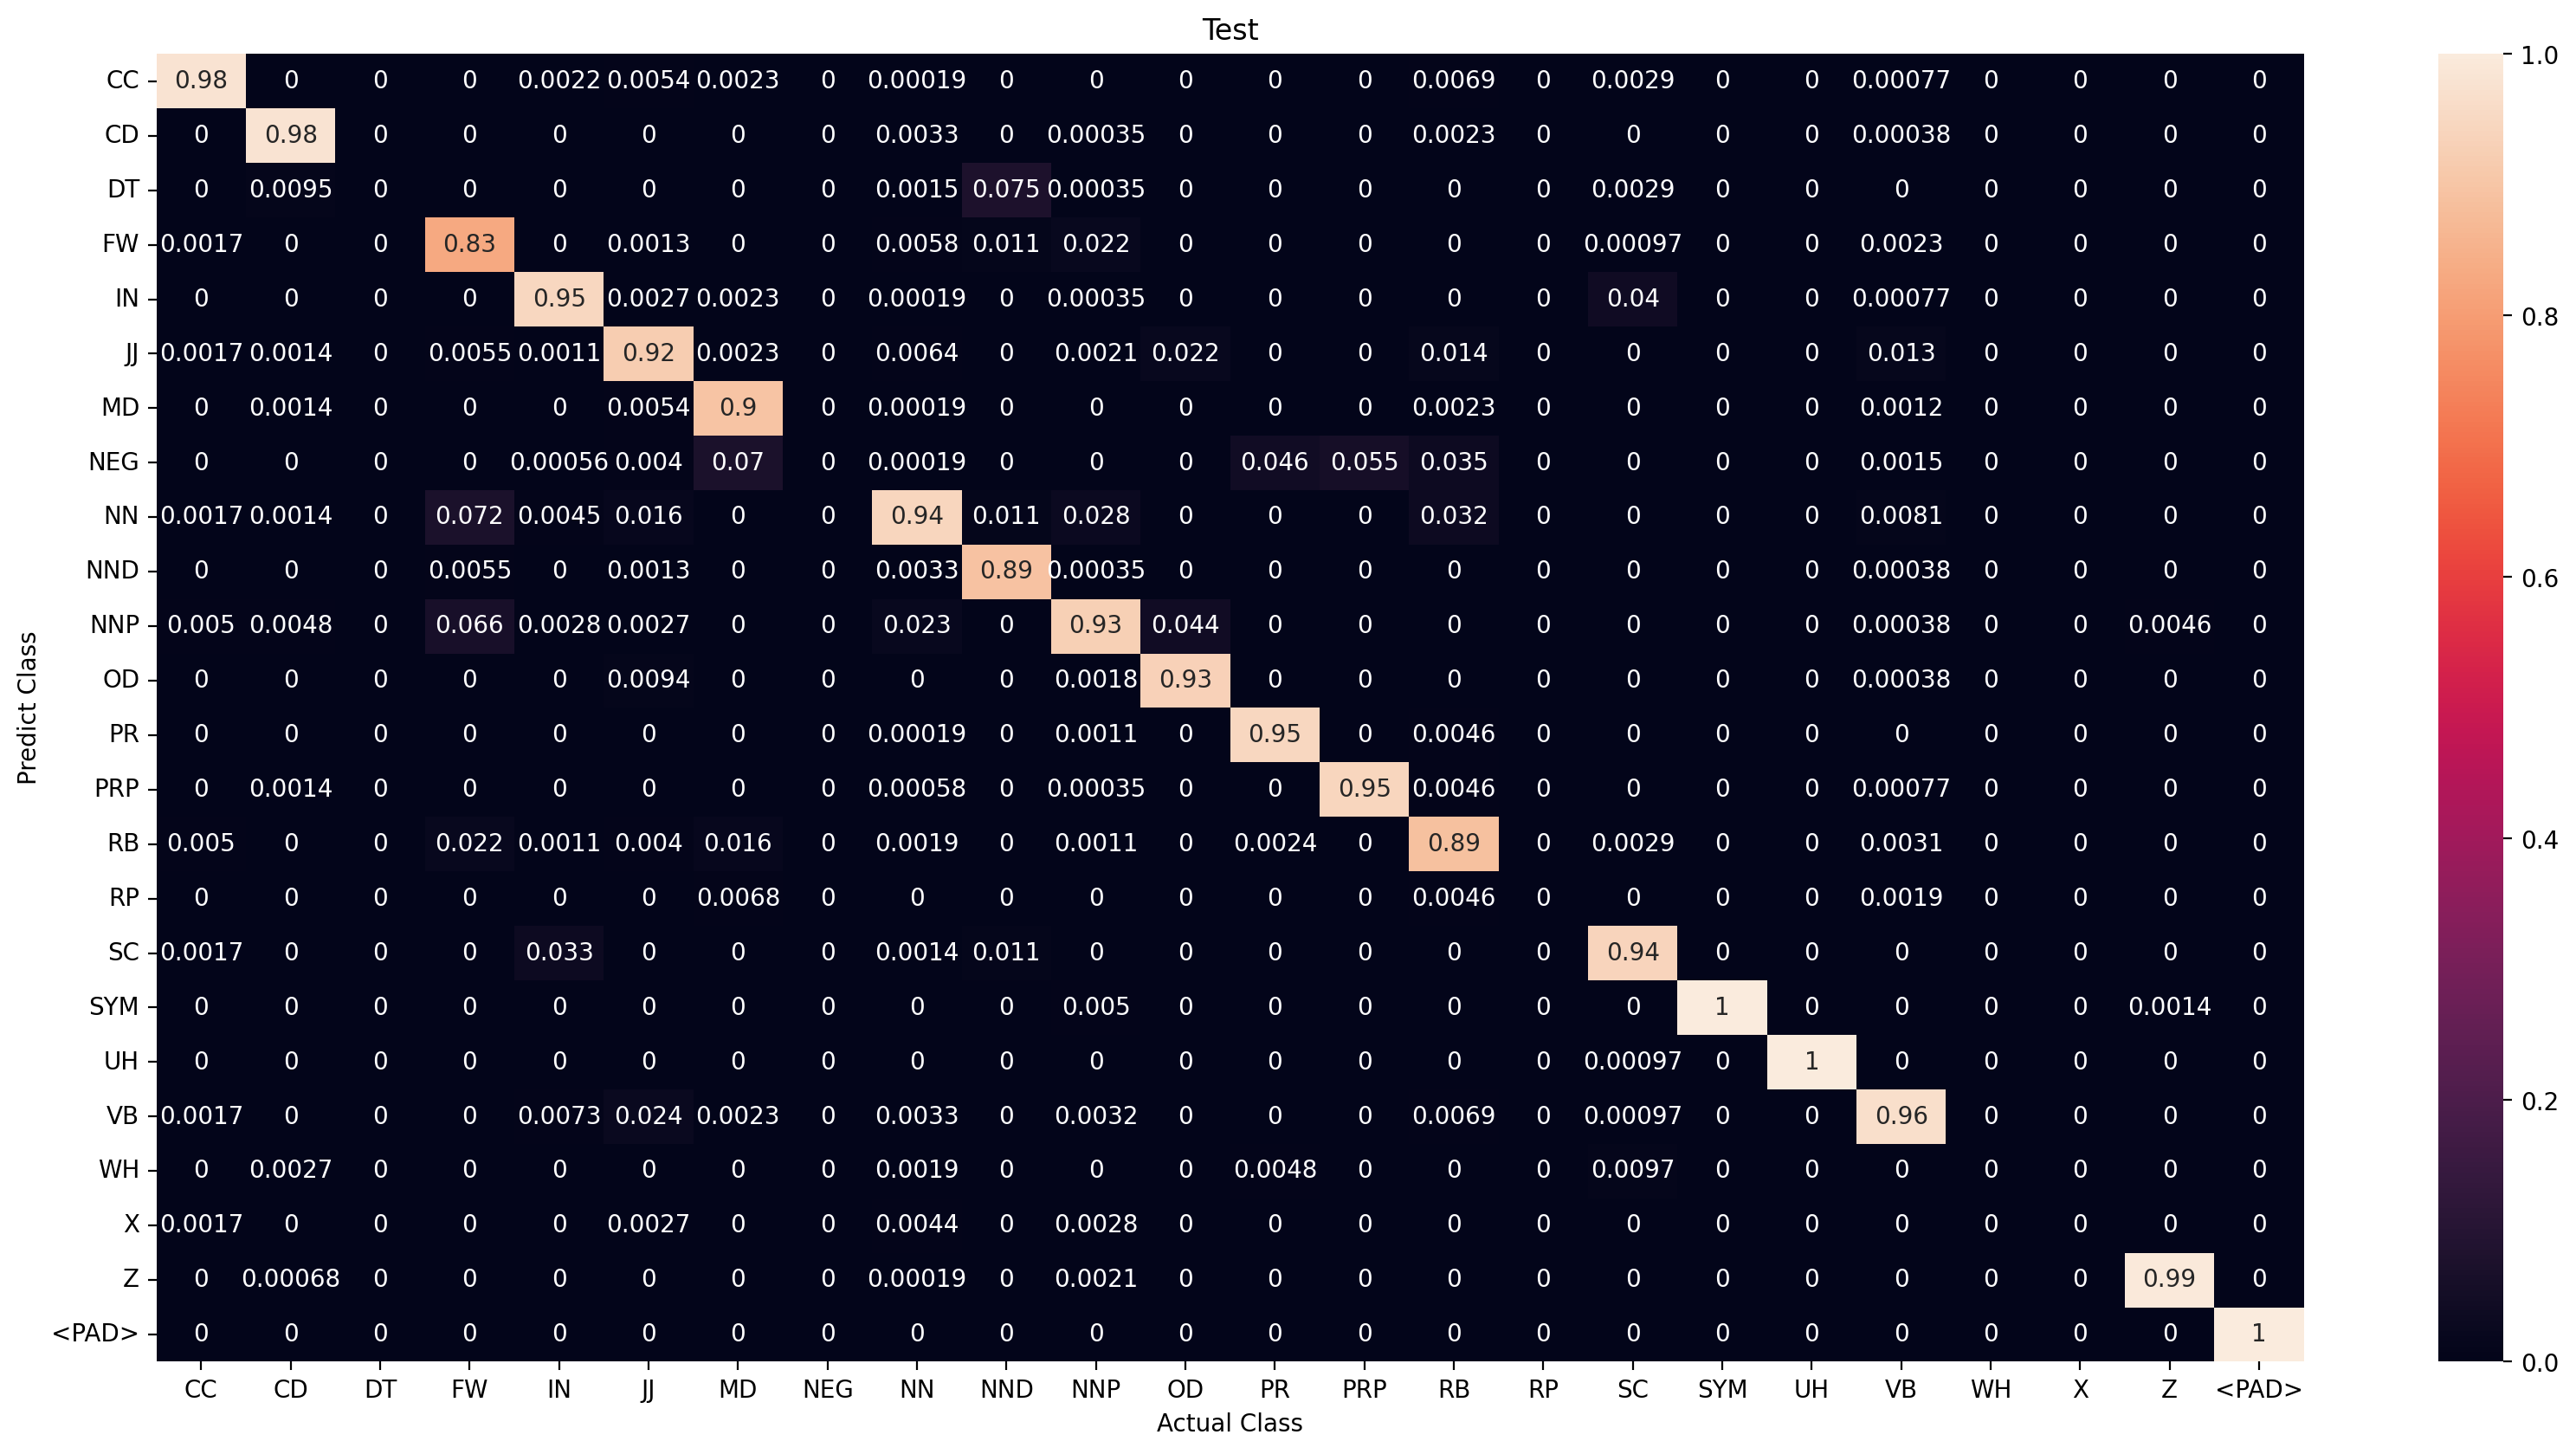

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5203       | CC    : 143      |
| CD    : 12730  | CD    : 12565      | CD    : 165      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1402       | FW    : 212      |
| IN    : 15342  | IN    : 15229      | IN    : 113      |
| JJ    : 6981   | JJ    : 6512       | JJ    : 469      |
| MD    : 3799   | MD    : 3700       | MD    : 99       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43868      | NN    : 501      |
| NND   : 1047   | NND   : 861        | NND   : 186      |
| NNP   : 25175  | NNP   : 24730      | NNP   : 445      |
| OD    : 524    | OD    : 505        | OD    : 19       |
| PR    : 3880   | PR    : 3837       | PR    : 43       |
| PRP   : 5471   | PRP   : 5394       | PRP   : 77       |
| RB    : 3477   | RB    : 3328       | RB    : 149      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 10957
Wrong prediction            : 849
Percentage correct oov pred : 92.80874131797391

Validation
Number OOV token            : 3366
Correct prediction          : 2953
Wrong prediction            : 413
Percentage correct oov pred : 87.73024361259655

Test
Number OOV token            : 1390
Correct prediction          : 1231
Wrong prediction            : 159
Percentage correct oov pred : 88.56115107913669



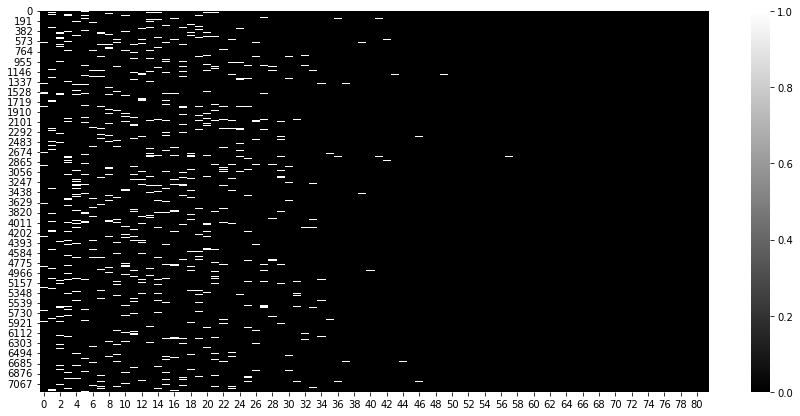

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

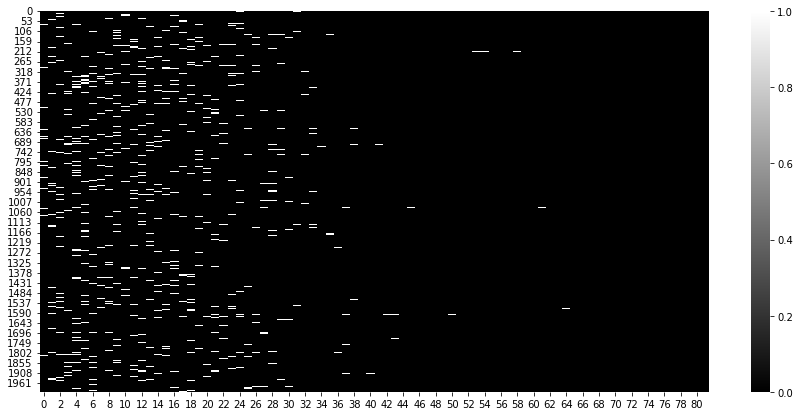

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

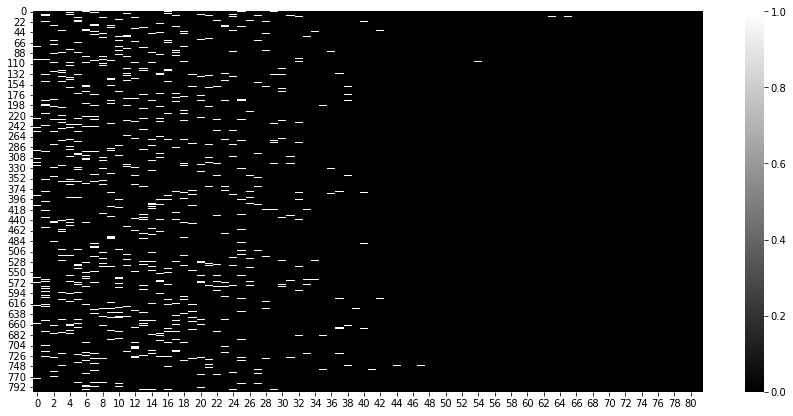

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);